In [1]:
# Importing required libraries
from sodapy import Socrata
import requests

#from mpl_toolkits.basemap import Basemap
from matplotlib import cm

import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np

from haversine import haversine
from scipy.spatial.distance import euclidean , cityblock
from geopy.distance import great_circle
from math import *

from bokeh.io import output_notebook,show
from bokeh.models import HoverTool
from bokeh.plotting import figure
from bokeh.palettes import Spectral4

output_notebook()

import os.path

import datashader as ds
import datashader.transfer_functions as dtf
from datashader.colors import colormap_select as cm, inferno, viridis
from datashader.utils import lnglat_to_meters

import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from matplotlib.colors import LinearSegmentedColormap

# Datashader helper function:
def bg(img): return dtf.set_background(img, "black")

%matplotlib inline
mpl.rcParams['figure.dpi'] = 130

import holoviews as hv
import geoviews as gv
import dask.dataframe as dd
import cartopy.crs as ccrs
from holoviews.operation.datashader import datashade
from holoviews.operation.datashader import aggregate

Loading BokehJS ...

In [2]:
# Importing required API(Yellow Trip Data-2015-January-June)
client = Socrata("data.cityofnewyork.us",
                  "woqOj0yWsQzkpr7i6BVEGMKqV",    # Using my account credentials to get access to API
                  "puneetag@buffalo.edu",         # NOTE: Use your own account credentials.
                  "Cobrasss02$")
results = client.get("2yzn-sicd", limit=1000000)  # Importing first 1000000 rows of data

In [3]:
# Creating the source dataframe for visualization
train_data = pd.DataFrame.from_records(results)

In [4]:
# Acquiring columns of interest
data = pd.DataFrame(train_data, columns=['pickup_datetime','dropoff_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','fare_amount','passenger_count','trip_distance'])

In [5]:
# Function to convert datetime datatype to just date
import datetime
def date1(tmp):
    dt=datetime.datetime.strptime(tmp,'%Y-%m-%dT%H:%M:%S.000')
    dt.date()
    dd=dt.date()
    return (dd)
data["Pickup Date"]=data["pickup_datetime"].apply(date1)
data["Dropoff Date"]=data["dropoff_datetime"].apply(date1)

In [6]:
# Function to convert datetime datatype to just time
def date2(tmp):
    dt=datetime.datetime.strptime(tmp,'%Y-%m-%dT%H:%M:%S.000')
    dt.time()
    dd=dt.time()
    return (dd)
data["Pickup time"]=data["pickup_datetime"].apply(date2)
data["Dropoff time"]=data["dropoff_datetime"].apply(date2)

In [7]:
# Convert columns with numeric values to float datatype
data['pickup_latitude'] = data['pickup_latitude'].astype(float)
data['pickup_longitude'] = data['pickup_longitude'].astype(float)
data['dropoff_latitude'] = data['dropoff_latitude'].astype(float)
data['dropoff_longitude'] = data['dropoff_longitude'].astype(float)
data['fare_amount'] = data['fare_amount'].astype(float)
data['passenger_count'] = data['passenger_count'].astype(float)
data['trip_distance'] = data['trip_distance'].astype(float)

In [8]:
# Creating a copy of dataframe 'data'
train=data.copy()

In [9]:
# Filtering the data so as to get the desired borders of NYC
west, south, east, north = -74.03, 40.63, -73.77, 40.85

train = train[(train.pickup_latitude> south) & (train.pickup_latitude < north)]
train = train[(train.dropoff_latitude> south) & (train.dropoff_latitude < north)]
train = train[(train.pickup_longitude> west) & (train.pickup_longitude < east)]
train = train[(train.dropoff_longitude> west) & (train.dropoff_longitude < east)]

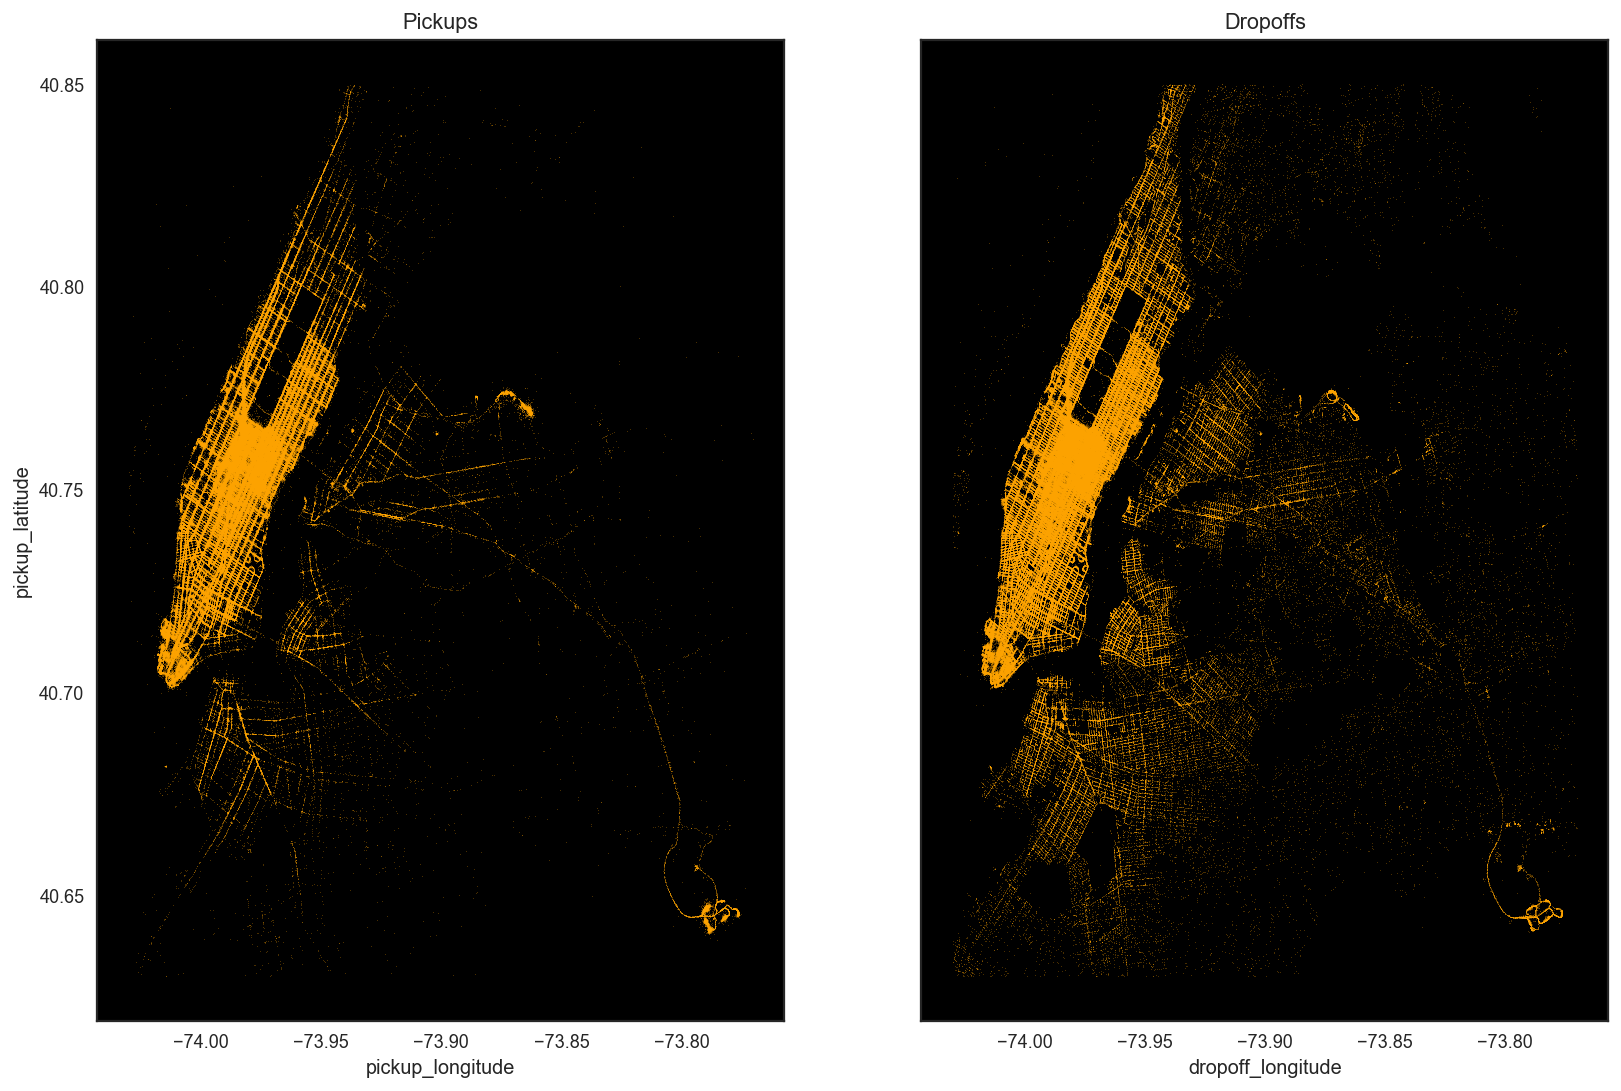

In [10]:
# Creating a geo-spatial plot for taxi pick-ups and drop-offs in NYC in 2015
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

train.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='orange', 
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Pickups")
ax1.set_facecolor('black')

train.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='orange', 
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Dropoffs")
ax2.set_facecolor('black')

In [11]:
# Creating a copy of dataframe 'train' and generatinf a column of unique ids for each taxi trip
df=train.copy()
df['id'] = np.random.randint(1,50000, size=len(df))
df=df[df!=0]
df = df.dropna(axis=0)

In [12]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees).
    Source: https://gis.stackexchange.com/a/56589/15183
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    meters = 1000 * 6367 * c
    return meters

df['hdist'] = haversine(df.pickup_longitude, df.pickup_latitude,
                        df.dropoff_longitude, df.dropoff_latitude)

# Add the log haversine distance:

df['log_hdist'] = np.log(1 + df['hdist'])

# Projects longitude-latitude coordinates into Web Mercator(https://en.wikipedia.org/wiki/Web_Mercator) 
# coordinates (for visualization)

df['pickup_x'], df['pickup_y'] = lnglat_to_meters(df['pickup_longitude'], df['pickup_latitude'])
df['dropoff_x'], df['dropoff_y'] = lnglat_to_meters(df['dropoff_longitude'], df['dropoff_latitude'])

In [13]:
# Visualization of taxi trip density in NYC
def get_lines(df):
    return pd.DataFrame({
            'x': df[['dropoff_x', 'pickup_x']].assign(dummy=np.NaN).values.flatten(),
            'y': df[['dropoff_y', 'pickup_y']].assign(dummy=np.NaN).values.flatten()})

lines = get_lines(df[lambda x: x.hdist < 2000])

# Bounding box where most of the data is:
nyc = {'x_range': (40.635, 40.86), 'y_range': (-74.03,-73.77)}

# Bounding box converted to Web mercator coordinates
bottom_left = lnglat_to_meters(nyc['y_range'][0], nyc['x_range'][0])
top_right = lnglat_to_meters(nyc['y_range'][1], nyc['x_range'][1])
nyc_m = {'x_range': (bottom_left[0], top_right[0]), 'y_range': (bottom_left[1], top_right[1])}

cvs = ds.Canvas(plot_width=2000, plot_height=2000, **nyc_m)
agg = cvs.line(lines, 'x', 'y', ds.count())
bg(dtf.shade(agg, cmap=cm(inferno, 0.1), how='log'))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


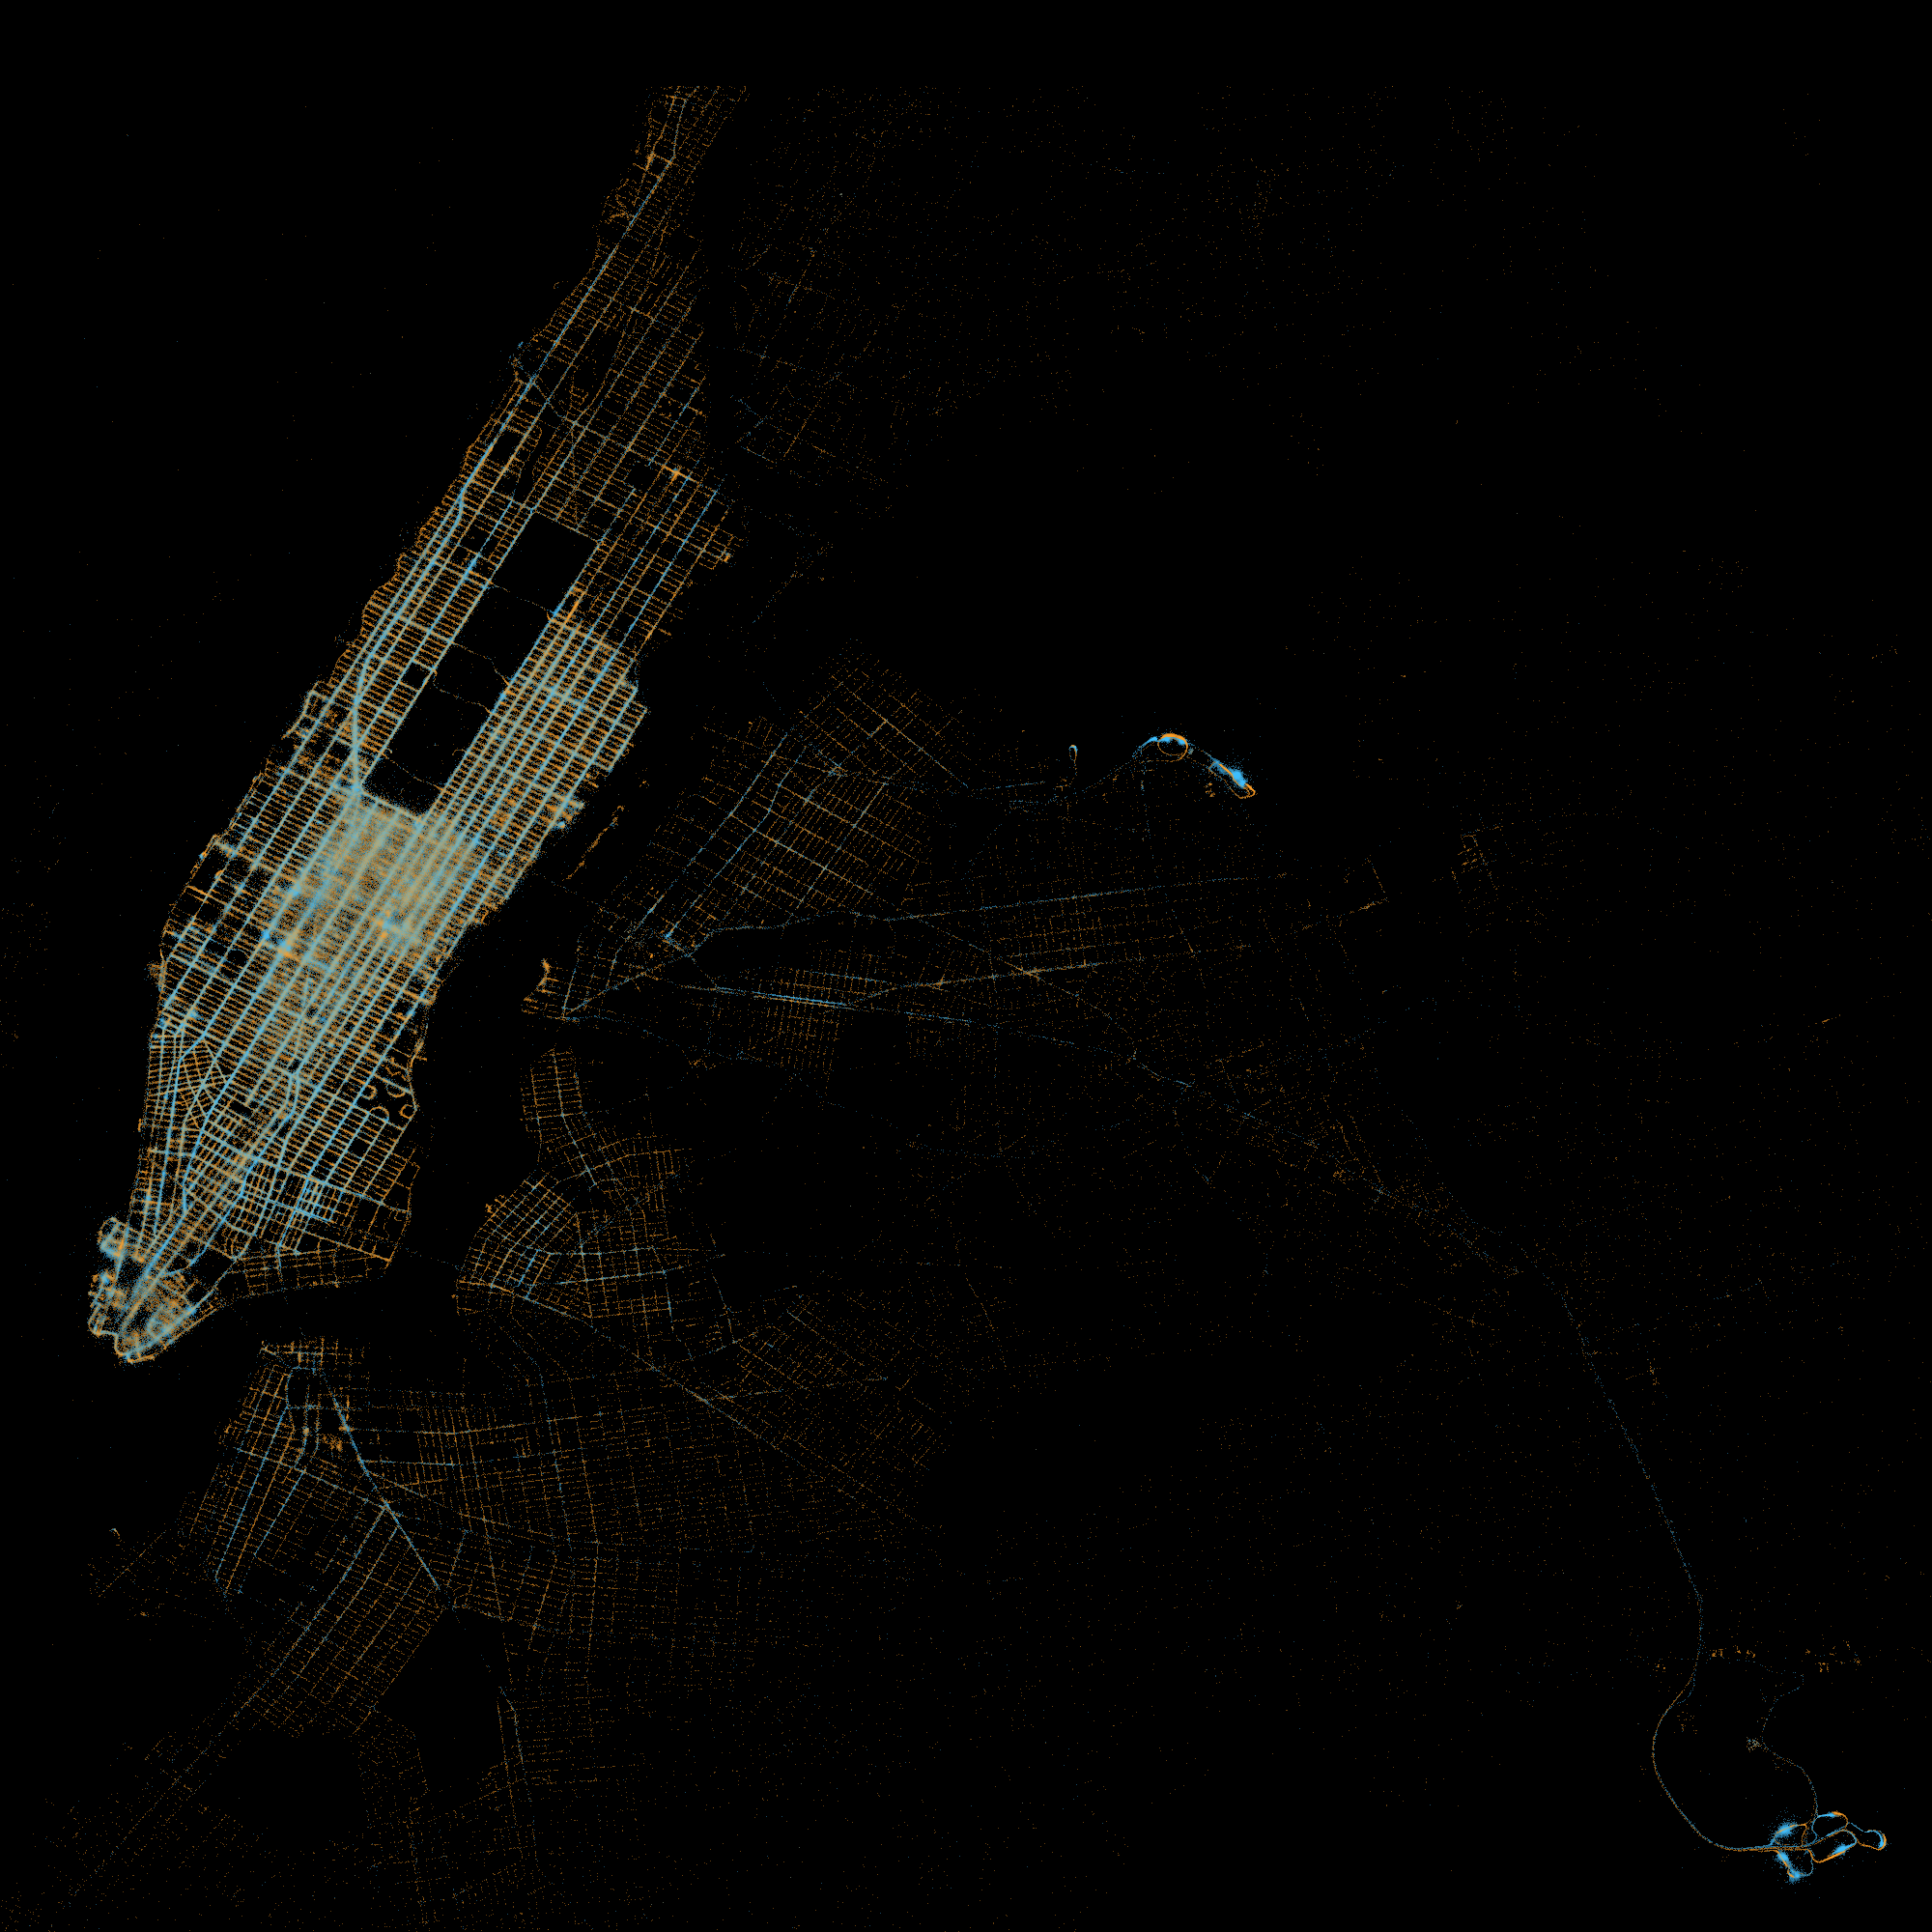

In [14]:
src = df[['pickup_x', 'pickup_y']].rename(columns={'pickup_x':'x', 'pickup_y':'y'})
dst = df[['dropoff_x', 'dropoff_y']].rename(columns={'dropoff_x':'x', 'dropoff_y':'y'})

all_pts = pd.concat({'pickup': src, 'dropoff': dst}, ignore_index=False, names=['type']).reset_index(0).reset_index(drop=True)
all_pts['type'] = all_pts['type'].astype('category')

cvs = ds.Canvas(plot_width=2000, plot_height=2000, **nyc_m)
agg = cvs.points(all_pts, 'x', 'y', ds.count_cat('type'))
bg(dtf.shade(agg, color_key={'dropoff':'#FF9E25', 'pickup':'#3FBFFF'}, how='eq_hist', min_alpha=100))

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
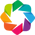

:AdjointLayout
   :DynamicMap   []
      :Overlay
         .Image.I :Image   [lon,lat]   (Count)
         .HLine.I :HLine   [x,y]
         .VLine.I :VLine   [x,y]
   :DynamicMap   []
      :Curve   [lat]   (Count)

In [15]:
# Hover plot for taxi pickups in NYC
hv.extension('bokeh')

# Set plot and style options
hv.util.opts('Image [width=800 height=800 shared_axes=False logz=True] {+axiswise} ')
hv.util.opts("HLine VLine (color='white' line_width=1) Layout [shared_axes=False] ")
hv.util.opts("Curve [xaxis=None yaxis=None show_grid=False, show_frame=False] (color='orangered') {+framewise}")


# Reproject points from Mercator to PlateCarree (latitude/longitude)
points = gv.Points(df, kdims=['pickup_x', 'pickup_y'], vdims=[], crs=ccrs.GOOGLE_MERCATOR)
projected = gv.operation.project_points(points, projection=ccrs.PlateCarree())
projected = projected.redim(pickup_x='lon', pickup_y='lat')

# Use datashader to rasterize and linked streams for interactivity
agg = aggregate(projected, link_inputs=True, x_sampling=0.0001, y_sampling=0.0001)
pointerx = hv.streams.PointerX(x=-74, source=projected)
pointery = hv.streams.PointerY(y=40.8,  source=projected)
vline = hv.DynamicMap(lambda x: hv.VLine(x), streams=[pointerx])
hline = hv.DynamicMap(lambda y: hv.HLine(y), streams=[pointery])

sampled = hv.util.Dynamic(agg, operation=lambda obj, x: obj.sample(lon=x),
                          streams=[pointerx], link_inputs=False)

hvobj = ((agg * hline * vline) << sampled.opts(plot={'Curve': dict(width=100)}))
hvobj

In [16]:
# Visualization for taxi dropoffs
url = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.jpg'
tile_opts  = dict(width=1000,height=600,xaxis=None,yaxis=None,bgcolor='black',show_grid=False)
map_tiles  = gv.WMTS(url).opts(style=dict(alpha=0.5), plot=tile_opts)
points     = hv.Points(df, ['dropoff_x', 'dropoff_y'])
taxi_trips = datashade(points, x_sampling=1, y_sampling=1, cmap=["darkblue", "lightcyan"], width=1000, height=600)

map_tiles * taxi_trips

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
